# Adjoint Optimization: High-Dimensional Gradient-Based Refinement

> In the previous notebook, we used Bayesian Optimization to find a good starting design. The strength of that global optimization approach was its ability to efficiently search a low-dimensional parameter space. However, it was limited: we assumed the grating was uniform, with every tooth and gap being identical.

> To push the performance further, we need to apodize the grating, which means varying the dimensions of each tooth individually to better match the profile of the incoming Gaussian beam. This drastically increases the number of design parameters. For our 15-element dual-layer grating, the design space just expanded from 5 global parameters to over 60 individual feature dimensions!

> For such a high-dimensional problem, a global search is no longer efficient. In this notebook, we switch to a powerful local, gradient-based optimization technique, enabled by the adjoint method, to refine our design.

## The Power of the Adjoint Method

The key challenge in gradient-based optimization is computing the gradient itself. A naive approach like finite differences would require N+1 simulations to find the gradient with respect to N parameters. For our ~60 parameters, this is far too slow.

This is where the adjoint method comes in. Tidy3D's automatic differentiation capability uses this method under the hood. It allows us to compute the gradient of our objective function (the coupling efficiency) with respect to all design parameters simultaneously in just two simulations per iteration, regardless of how many parameters there are. This efficiency is what makes it possible to locally optimize structures with thousands of free parameters. We start from the global design found earlier and use these gradients to walk toward a nearby, higher-performance solution.

In [ ]:
import json
from copy import deepcopy
from pathlib import Path

import autograd.numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
from autograd import value_and_grad
from optim import adam_update, apply_updates, clip_params, init_adam
from setup import (
    center_wavelength,
    first_gap_sin,
    get_mode_monitor_power,
    make_simulation,
    max_gap_si,
    max_gap_sin,
    max_width_si,
    max_width_sin,
    min_gap_si,
    min_gap_sin,
    min_width_si,
    min_width_sin,
    num_elements,
)
from tidy3d import web

In [2]:
def objective(params):
    """Objective function for adjoint optimization.

    Takes a dictionary of geometry parameters and returns a scalar loss.
    The function is differentiable via autograd so the adjoint method can
    supply gradients for every parameter in one shot.

    Parameters
    ----------
    params:
        Dictionary holding the current grating geometry arrays.

    Returns
    -------
    float
        Negative of the coupling efficiency so gradient descent maximizes power.
    """
    # Build the tidy3d simulation with the current parameters. Autograd traces
    # everything through the power extraction so the adjoint gradient can be
    # computed efficiently.
    sim = make_simulation(
        params["widths_si"],
        params["gaps_si"],
        params["widths_sin"],
        params["gaps_sin"],
        first_gap_si=params["first_gap_si"],
        first_gap_sin=params["first_gap_sin"],
    )

    sim_data = web.run(sim, task_name="gc_adjoint", verbose=False)

    # Convert the mode monitor result into a scalar objective (negative power)
    # so minimization increases the coupled power at the target wavelength.
    power_da = get_mode_monitor_power(sim_data)
    freq0 = td.C_0 / center_wavelength
    target_power = power_da.sel(f=freq0, method="nearest")
    return -target_power.item()

## High-Dimensional Parameterization

We load the best uniform design from the Bayesian search and expand those scalars into per-tooth arrays. Each layer now has individual widths and gaps, and `first_gap_si` remains a crucial phase-matching variable.

In [3]:
scalars = {}
with Path("./results/gc_bayes_opt_best.json").open("r", encoding="utf-8") as f:
    data = json.load(f)
    for key in data:
        scalars[key] = float(data[key])

num_iters = 80

params0 = {
    "widths_si": np.full(num_elements, scalars["width_si"]),
    "gaps_si": np.full(num_elements, scalars["gap_si"]),
    "widths_sin": np.full(num_elements, scalars["width_sin"]),
    "gaps_sin": np.full(num_elements, scalars["gap_sin"]),
    "first_gap_si": scalars["first_gap_si"],
    "first_gap_sin": first_gap_sin,
}

bounds = {
    "widths_si": (min_width_si, max_width_si),
    "gaps_si": (min_gap_si, max_gap_si),
    "widths_sin": (min_width_sin, max_width_sin),
    "gaps_sin": (min_gap_sin, max_gap_sin),
    "first_gap_si": (None, None),
    "first_gap_sin": (min_gap_sin, None),
}

In [4]:
vg_fun = value_and_grad(objective)
params = deepcopy(params0)
opt_state = init_adam(params, lr=1e-2)
target_powers = []

## Running the Gradient Descent

Each iteration proceeds as follows:
1. Evaluate both the loss and gradient with `value_and_grad`.
2. Use the Adam optimizer to compute a parameter update with momentum.
3. Apply the update to the parameters.
4. Clip the result to obey fabrication bounds.

In [5]:
for n in range(num_iters):
    value, grad = vg_fun(params)
    target_power = -value

    target_powers.append(target_power)
    print(f"iter {n}: target_power={target_power:.4f}")

    updates, opt_state = adam_update(grad, opt_state)
    params = apply_updates(params, updates)
    params = clip_params(params, bounds)

iter 0: target_power=0.3426
iter 1: target_power=0.3342
iter 2: target_power=0.3857
iter 3: target_power=0.4068
iter 4: target_power=0.4014
iter 5: target_power=0.4060
iter 6: target_power=0.4225
iter 7: target_power=0.4361
iter 8: target_power=0.4367
iter 9: target_power=0.4350
iter 10: target_power=0.4383
iter 11: target_power=0.4460
iter 12: target_power=0.4502
iter 13: target_power=0.4528
iter 14: target_power=0.4527
iter 15: target_power=0.4522
iter 16: target_power=0.4579
iter 17: target_power=0.4630
iter 18: target_power=0.4638
iter 19: target_power=0.4651
iter 20: target_power=0.4674
iter 21: target_power=0.4704
iter 22: target_power=0.4720
iter 23: target_power=0.4718
iter 24: target_power=0.4754
iter 25: target_power=0.4794
iter 26: target_power=0.4783
iter 27: target_power=0.4805
iter 28: target_power=0.4838
iter 29: target_power=0.4860
iter 30: target_power=0.4885
iter 31: target_power=0.4889
iter 32: target_power=0.4911
iter 33: target_power=0.4933
iter 34: target_power=0.

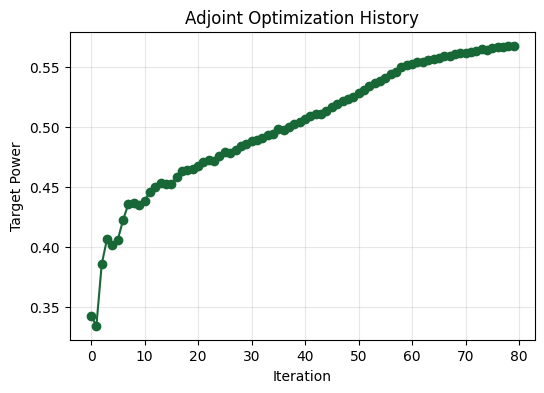

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(len(target_powers)), target_powers, marker="o")
ax.set_xlabel("Iteration")
ax.set_ylabel("Target Power")
ax.set_title("Adjoint Optimization History")
ax.grid(True, alpha=0.3)
plt.show()

## Visualizing the Results

The steadily rising power confirms the adjoint-driven search is homing in on a better design.

In [7]:
def compute_spectrum(param_set, task_name):
    sim = make_simulation(
        param_set["widths_si"],
        param_set["gaps_si"],
        param_set["widths_sin"],
        param_set["gaps_sin"],
        first_gap_si=param_set["first_gap_si"],
        first_gap_sin=param_set["first_gap_sin"],
    )
    sim_data = web.run(sim, task_name=task_name, verbose=False)
    power_da = get_mode_monitor_power(sim_data)
    freqs = power_da.coords["f"].values
    wavelengths = td.C_0 / freqs
    power = np.squeeze(power_da.data)
    sort_idx = np.argsort(wavelengths)
    wavelengths = wavelengths[sort_idx]
    power = np.array(power)[sort_idx]
    return wavelengths, power

## Performance Payoff

Comparing the spectra shows the apodized design significantly boosts coupling near 1.55 µm relative to the uniform baseline from Bayesian optimization.

In [8]:
w_before, p_before = compute_spectrum(params0, "gc_adjoint_before")
w_after, p_after = compute_spectrum(params, "gc_adjoint_after")

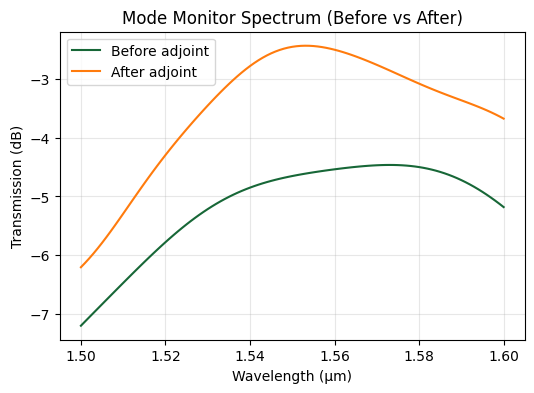

In [9]:
before_db = 10 * np.log10(p_before)
after_db = 10 * np.log10(p_after)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(w_before, before_db, label="Before adjoint")
ax.plot(w_after, after_db, label="After adjoint")
ax.set_xlabel("Wavelength (µm)")
ax.set_ylabel("Transmission (dB)")
ax.set_title("Mode Monitor Spectrum (Before vs After)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

## Final Apodized Geometry

Visual inspection highlights the non-uniform duty cycle discovered by the optimizer to better mode-match the incident beam.

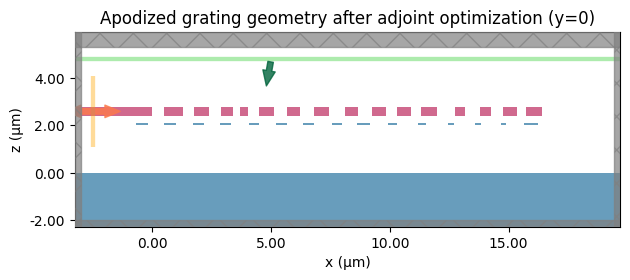

In [10]:
final_sim = make_simulation(
    params["widths_si"],
    params["gaps_si"],
    params["widths_sin"],
    params["gaps_sin"],
    first_gap_si=params["first_gap_si"],
    first_gap_sin=params["first_gap_sin"],
)
ax = final_sim.plot(y=0)
ax.set_title("Apodized grating geometry after adjoint optimization (y=0)")
plt.show()

Lastly, we need to export the optimized grating geometry for further analysis.

In [11]:
def serialize_params(param_dict):
    """Detach autograd containers into JSON-serializable Python objects."""
    return {
        "widths_si": [float(value) for value in param_dict["widths_si"]],
        "gaps_si": [float(value) for value in param_dict["gaps_si"]],
        "widths_sin": [float(value) for value in param_dict["widths_sin"]],
        "gaps_sin": [float(value) for value in param_dict["gaps_sin"]],
        "first_gap_si": float(param_dict["first_gap_si"]),
        "first_gap_sin": float(param_dict["first_gap_sin"]),
    }


export_path = Path("./results/gc_adjoint_best.json")
export_path.parent.mkdir(parents=True, exist_ok=True)

payload = serialize_params(params)
payload["target_power"] = float(target_powers[-1]) if target_powers else None

with export_path.open("w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2)

print(f"Saved adjoint design to {export_path.resolve()}")

Saved adjoint design to /home/yannick/flexcompute/worktrees/seminar_notebooks/docs/notebooks/2025-10-09-invdes-seminar/results/gc_adjoint_best.json


## Conclusion and Next Steps

Switching to a gradient-based approach unlocked high-dimensional refinements and reduced the coupling loss by more than a decibel. The resulting design is finely tuned for nominal fabrication, so the next notebook introduces robust optimization to preserve performance under realistic manufacturing variations.